## load data

In [203]:
from mnist_poc import *
import matplotlib.pyplot as plt
from keras.models import load_model, Model

Xtrain, Xtest, ytrain, ytest = load_mnist()
noise = numpy.load(SOURCE + 'noise.npy') * 4
noise = numpy.repeat(noise, 2, axis=0)[:Xtrain.shape[0]]
noise = shuffle(noise, random_state=0)

# 1 for real images
real = numpy.random.randint(0, 2, size=Xtrain.shape[0]).astype(bool)

Xtest = Xtest + noise[:Xtest.shape[0]]
Xtrain[real] += noise[real]
# ytrain[real] *= 0
ytrain = [ytrain, to_categorical(real.astype(int), num_classes=2)]
ytest = [ytest, to_categorical([1,] * ytest.shape[0], num_classes=2)]
train_generator = datagenerator(Xtrain, *ytrain)

## Load models

In [226]:
# da = load_model('/Users/remydubois/Dropbox/Remy/results/mnist_da3/model-ckpt', 
#                    custom_objects={'reverse_grad':reverse_grad, 'digits_loss':digits_loss})
# noda = load_model('/Users/remydubois/Dropbox/Remy/results/mnist_noda/model-ckpt', 
#                    custom_objects={'reverse_grad':reverse_grad, 'digits_loss':digits_loss})
embedder_da = Model(da.input, [da.layers[-2].output, da.layers[-8].output])
embedder_noda = Model(noda.input, [noda.layers[-1].output, noda.layers[-4].output])

## Predict

In [242]:
# noda.summary()
# embedder_noda.output[1].shape
import tqdm
Ydomain = []
Ydigit = []
featuresda = []
featuresnoda = []
digitsda = []
digitsnoda = []
for i in tqdm.tqdm(range(200)):
    x, y = next(train_generator)
    Ydomain.append(y[1])
    Ydigit.append(y[0])
    
    digitda, featureda = embedder_da.predict(x)
#     print(digitda.shape)
#     print(featureda.shape)
    featuresda.append(featureda)
    digitsda.append(digitda)

    digitnoda, featurenoda = embedder_noda.predict(x)
#     print(digitnoda.shape)
    featuresnoda.append(featurenoda)
    digitsnoda.append(digitnoda)

featuresda = numpy.concatenate(featuresda, axis=0)
featuresnoda = numpy.concatenate(featuresnoda, axis=0)
digitsda = numpy.argmax(numpy.concatenate(digitsda, axis=0), axis=1)
digitsnoda = numpy.argmax(numpy.concatenate(digitsnoda, axis=0), axis=1)
Ydomain = numpy.argmax(numpy.concatenate(Ydomain), axis=1)
Ydigit = numpy.argmax(numpy.concatenate(Ydigit), axis=1)

100%|██████████| 200/200 [00:12<00:00, 15.83it/s]


## Project

In [249]:
from MulticoreTSNE import MulticoreTSNE
tsne = MulticoreTSNE(n_components=2, n_jobs=4, verbose=11)
planda = tsne.fit_transform(featuresda)
plannoda = tsne.fit_transform(featuresnoda)

In [259]:
# print(Ydigit)
# print((digitsda==Ydigit).mean())
# print((digitsnoda==Ydigit).mean())

[2 6 1 ... 4 8 6]
0.8708
0.7332


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Text(0.5,1,'Trained on source')

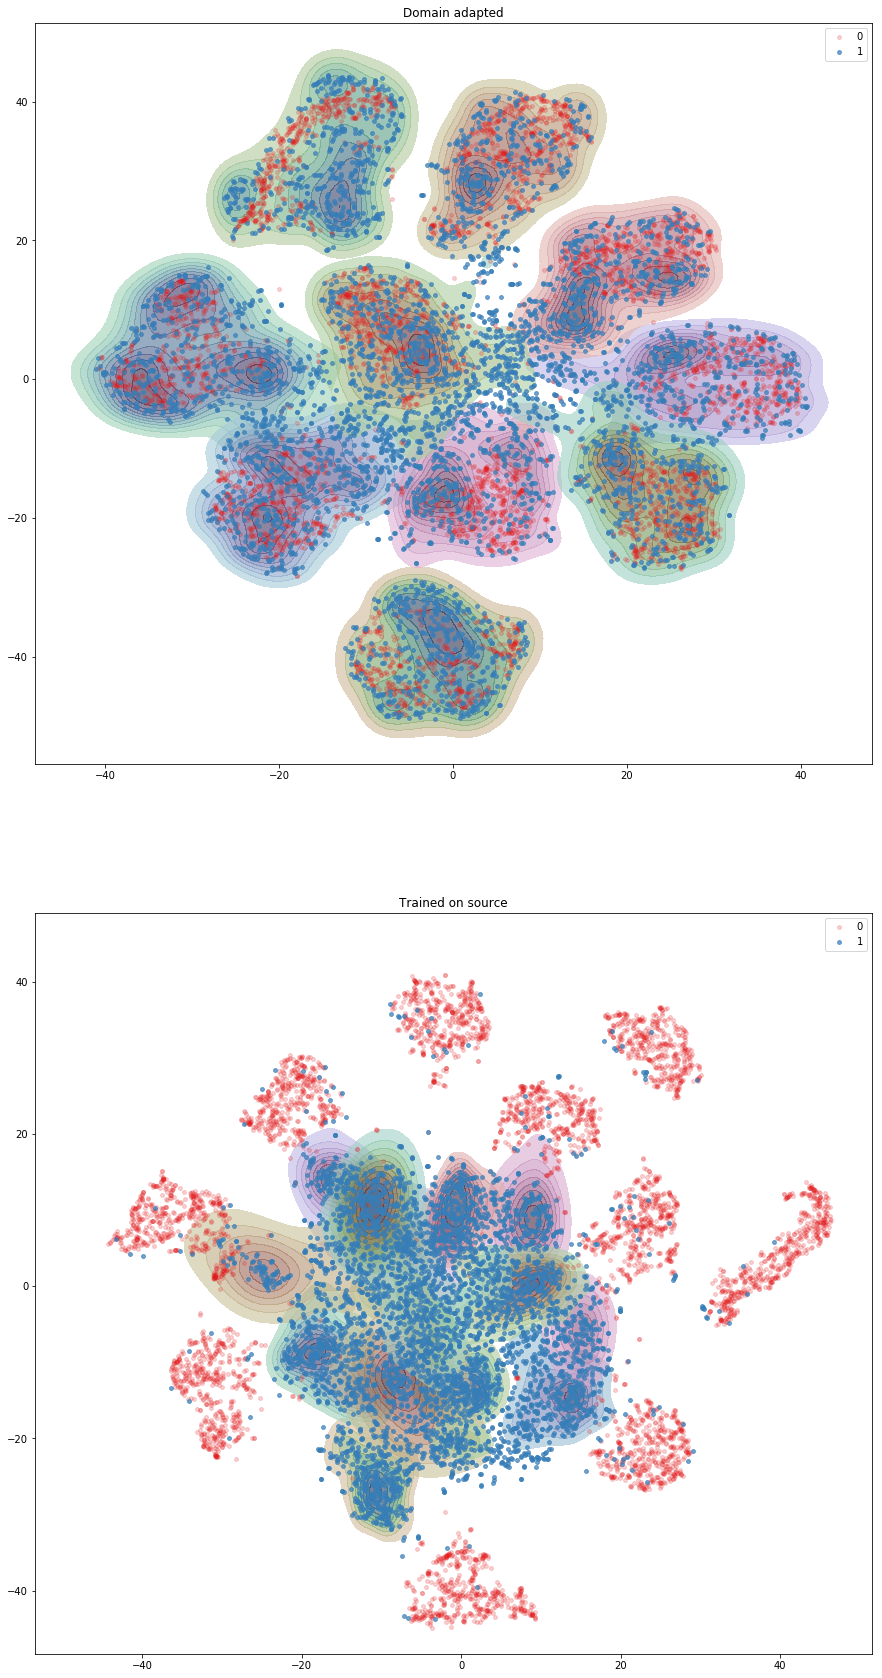

In [271]:
# print(numpy.bincount(Ydigit))
import seaborn as sns
cmap = plt.cm.Set1
cmap2 = plt.cm.viridis

color_array = numpy.array(cmap2.colors)

f, (ax0, ax1) = plt.subplots(figsize=(15, 30), nrows=2)
for y in tqdm.tqdm(range(10)):
    sl = (digitsda==Ydigit)*(Ydigit==y)
    sns.kdeplot(planda[sl*(Ydomain==1), 0], 
            planda[sl*(Ydomain==1), 1], 
            ax = ax0,
            shade=True,
            shade_lowest=False,
            alpha=0.6,
            cmap = sns.cubehelix_palette(8, start=.5, rot=-1 +y*0.2, as_cmap=True))
    sns.kdeplot(plannoda[sl*(Ydomain==1), 0], 
        plannoda[sl*(Ydomain==1), 1], 
            alpha=0.6,
        shade=True,
        shade_lowest=False,
        ax = ax1,
       cmap = sns.cubehelix_palette(8, start=.5, rot=-1 +y*0.2, as_cmap=True))

for y in [0, 1]:
    sl = Ydomain==y

#     ax0.scatter(*zip(*planda[sl]),
#               facecolors=[cmap2(int(i*cmap2.N/10)) for i in Ydigit[sl]],
#                s=50,
#                alpha=0.4)
    ax0.scatter(*zip(*planda[sl]),
              label=y,
                alpha=0.2 + 0.5*y,
                s=15,
              facecolors=cmap(int(y)))
    ax1.scatter(*zip(*plannoda[sl]),
              label=y,
                alpha=0.2 + 0.5*y,
                s=15,
              facecolors=cmap(int(y)))
ax0.legend()
ax0.set_title('Domain adapted')

ax1.legend()
ax1.set_title('Trained on source')


## Images

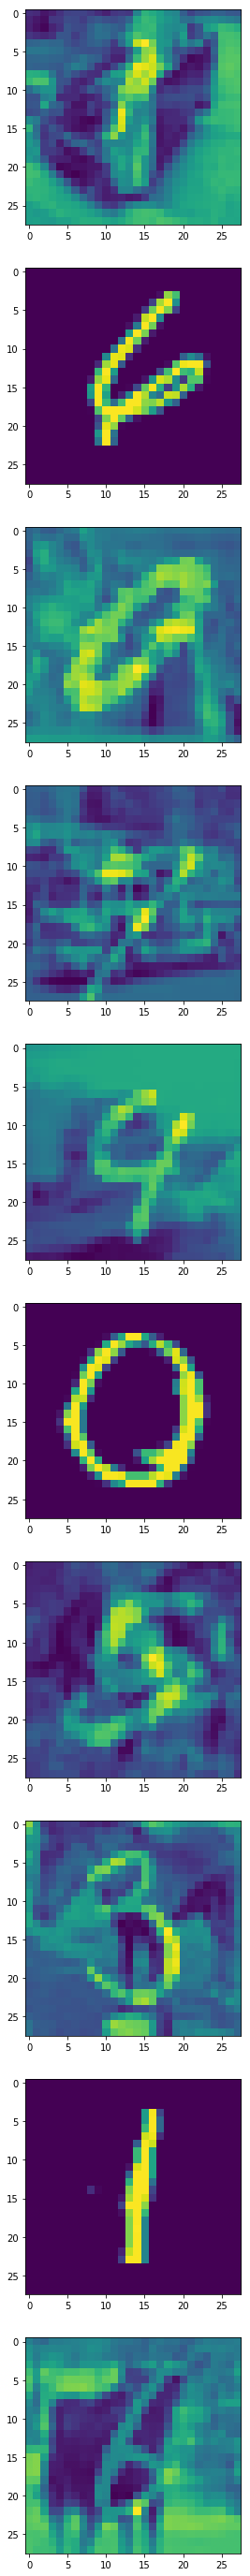

In [272]:
x, _ = next(train_generator)
f, ax = plt.subplots(nrows=10, figsize=(5, 50))
ax = iter(ax.ravel())
for _ in range(10):
    next(ax).imshow(x[_,:,:,0])

In [274]:
pred = tf.constant([[0.1, 0.9], [0.1, 0.9]])
true = tf.constant([[0, 1], [0, 1]])


In [1]:
from main import *

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
Xtrain, Xtest, ytrain, ytest = load_mnist()
print('train classes', numpy.sum(ytrain, axis=0))
print('test classes', numpy.sum(ytest, axis=0))
noise = numpy.load(SOURCE + 'noise.npy') * 1
noise = numpy.repeat(noise, 2, axis=0)[:Xtrain.shape[0]]
noise = shuffle(noise, random_state=0)

# 1 for real images
synratio = 0.5
realtrain = numpy.array([True, ] * math.ceil((1 - synratio) * Xtrain.shape[0]) + [False, ] * math.ceil(synratio * Xtrain.shape[0]))[:Xtrain.shape[0]]
numpy.random.shuffle(realtrain)
# realtest = numpy.array([True, ] * math.floor((1 - synratio) * Xtest.shape[0]) + [False, ] * math.ceil(synratio * Xtest.shape[0]))
# numpy.random.shuffle(realtest) 
# realtrain = numpy.random.randint(0, 2, size=Xtrain.shape[0]).astype(bool)
realtest = numpy.random.randint(0, 2, size=Xtest.shape[0]).astype(bool)

Xtest[realtest] += noise[:Xtest.shape[0]][realtest]
ytest[numpy.logical_not(realtest)] *= 0 # This ensures that loss and acc are computed on real examples during testing
# ytest[realtest] *= 0
Xtrain[realtrain] += noise[realtrain]
ytrain[realtrain] *= 0 # This ensures that loss & acc are computed only on synthetic examples during training

ytrain = [ytrain, to_categorical(realtrain.astype(int), num_classes=2)]
ytest = [ytest, to_categorical(realtest.astype(int), num_classes=2)]

train_generator = datagenerator(numpy.kron(Xtrain, numpy.ones((1,2,2,1))), *ytrain, batch_size=100)
test_generator = datagenerator(numpy.kron(Xtest, numpy.ones((1,2,2,1))), *ytest, batch_size=100)

Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.
train classes [5128. 5896. 5195. 5249. 4968. 4725. 5183. 5364. 5115. 5177.]
test classes [1296. 1418. 1307. 1399. 1321. 1154. 1192. 1379. 1248. 1286.]


In [41]:
# lam = K.variable(numpy.array(0, dtype='float64'), name='lambda_grl')

# # Model
input_ = Input(shape=next(train_generator)[0].shape[1:])
output_ = SqueezeNetOutputDA(input_, 10, lam=lam, bypass='simple')
sqn_da = Model(input_, output_)
sqn_da.load_weights('/cbio/donnees/rdubois/results/sqn_mnist_dw_0.35_lam_0.9/model-ckpt')
embedder_da = Model(sqn_da.input, [sqn_da.layers[-2].output, sqn_da.layers[-9].output])
# print([l.name for l in sqn_da.layers])

In [42]:
import tqdm
Ydomain = []
Ydigit = []
featuresda = []
featuresnoda = []
digitsda = []
digitsnoda = []
for i in tqdm.tqdm(range(200)):
    x, y = next(train_generator)
    Ydomain.append(y[1])
    Ydigit.append(y[0])
    
    digitda, featureda = embedder_da.predict(x)
#     print(digitda.shape)
#     print(featureda.shape)
    featuresda.append(featureda)
    digitsda.append(digitda)

#     digitnoda, featurenoda = embedder_noda.predict(x)
# #     print(digitnoda.shape)
#     featuresnoda.append(featurenoda)
#     digitsnoda.append(digitnoda)

featuresda = numpy.concatenate(featuresda, axis=0)
# featuresnoda = numpy.concatenate(featuresnoda, axis=0)
digitsda = numpy.argmax(numpy.concatenate(digitsda, axis=0), axis=1)
# digitsnoda = numpy.argmax(numpy.concatenate(digitsnoda, axis=0), axis=1)
Ydomain = numpy.argmax(numpy.concatenate(Ydomain), axis=1)
Ydigit = numpy.argmax(numpy.concatenate(Ydigit), axis=1)

100%|██████████| 200/200 [00:05<00:00, 34.50it/s]


In [ ]:
from MulticoreTSNE import MulticoreTSNE
tsne = MulticoreTSNE(n_components=2, n_jobs=24, verbose=11)
planda = tsne.fit_transform(featuresda)
# plannoda = tsne.fit_transform(featuresnoda)

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score
cmap = plt.cm.Set1
cmap2 = plt.cm.viridis

color_array = numpy.array(cmap2.colors)

f, (ax0, ax1) = plt.subplots(figsize=(15, 30), nrows=2)
# for y in tqdm.tqdm(range(10)):
#     sl = (digitsda==y)
#     sns.kdeplot(planda[sl*(Ydomain==1), 0], 
#             planda[sl*(Ydomain==1), 1], 
#             ax = ax0,
#             shade=True,
#             shade_lowest=False,
#             alpha=0.6,
#             cmap = sns.cubehelix_palette(8, start=.5, rot=-1 +y*0.2, as_cmap=True))
# #     sns.kdeplot(plannoda[sl*(Ydomain==1), 0], 
# #         plannoda[sl*(Ydomain==1), 1], 
# #             alpha=0.6,
# #         shade=True,
# #         shade_lowest=False,
# #         ax = ax1,
# #        cmap = sns.cubehelix_palette(8, start=.5, rot=-1 +y*0.2, as_cmap=True))

for y in [0, 1]:
    sl = Ydomain==y

#     ax0.scatter(*zip(*planda[sl]),
#               facecolors=[cmap2(int(i*cmap2.N/10)) for i in Ydigit[sl]],
#                s=50,
#                alpha=0.4)
    ax0.scatter(*zip(*planda[sl]),
              label=y,
                alpha=0.2 + 0.5*y,
                s=15,
              facecolors=cmap(int(y)))
#     ax1.scatter(*zip(*plannoda[sl]),
#               label=y,
#                 alpha=0.2 + 0.5*y,
#                 s=15,
#               facecolors=cmap(int(y)))
ax0.legend()
# print(accuracy_score(Ydigit.astype(int), digitsda.astype(int)))
ax0.set_title('Domain adapted, acc on real:'+str(accuracy_score(Ydigit[Ydomain==1].astype(int), digitsda[Ydomain==1].astype(int))))

ax1.legend()
ax1.set_title('Trained on source')